#**`NB1_Classic_Model: Logistic Regression with TF-IDF Features`**
**`Author:`** `Arhaam Khan ` <br>
**`Student ID:`** `160287217  ` <br>
**`Email:`** `ana40@myseneca.ca` <br>

##**`Data Exploration & Preprocessing:`**

###**`Loading the data set`**

In [2]:
#mount gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#Reading the data from google drive
data=pd.read_csv('gdrive/MyDrive/SEA820_DataSets/AI_Human.csv')

In [5]:
#use a copy so that the changes made to the copy does not affect the original data set
#this is a good coding practice
df = data.copy()

**`About the data set`**
* `Source:`[AI vs Human](https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text)`Text dataset from Kaggle.`
* `This dataset is specifically curated for this classification challenge.`
* `The dataset includes student essays and other text forms, making it relevant and challenging.`
* `Each text sample is labeled as either 0 (human) or 1 (AI-generated).`


In [6]:
#print head
df.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


###**`Perform a thorough exploratory data analysis (EDA).`**

####**`Basic Exploration`**

In [7]:
#display info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487235 entries, 0 to 487234
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   text       487235 non-null  object 
 1   generated  487235 non-null  float64
dtypes: float64(1), object(1)
memory usage: 7.4+ MB


In [8]:
#shape shows 5000 rows and only 2 columns
print("The data set has the following dimensions for rows and columns: ", df.shape)

The data set has the following dimensions for rows and columns:  (487235, 2)


In [9]:
#columns text and label
columns=df.columns.to_list()
print("The data set has the following columns: ", columns)

The data set has the following columns:  ['text', 'generated']


In [10]:
#describe whole csv
df.describe()

,generated
count,487235.000000
mean,0.372383
std,0.483440
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [11]:
#describe 'text' column
df['text'].describe()

,text
count,487235
unique,487235
top,"Richard Non, Jimmy Carter, and Bob Dole and ot..."
freq,1


####**`Analyzing the text length`**

In [12]:
# Compute text lengths
df['text_length'] = df['text'].str.len()

<Axes: >

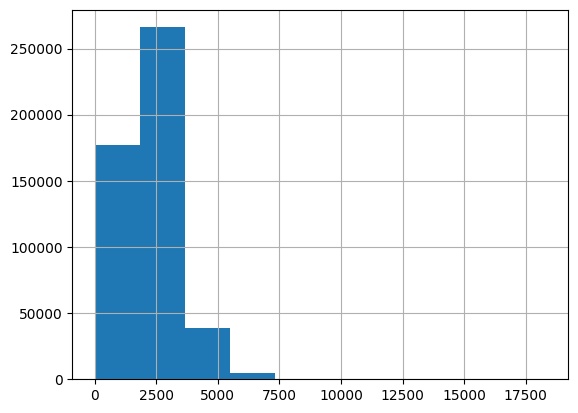

In [13]:
#Histogram representation of for number of characters
#text length includes spaces, special characters, etc.
#Thus, this is a represenation of the number of caharacters and not letters
df['text_length'].hist()


In [14]:
#Moving foward we will focus on just letters or in describe() non null enteries
# Summary statistics
summary = df['text_length'].describe()

#values
shortest = int(summary['min'])
longest = int(summary['max'])
avg = int(summary['mean'])

In [15]:
#display results
print(f"Shortest Text: {shortest} characters")
print(f"Longest Text: {longest} characters")
print(f"Average Text: {avg} characters (~{avg // 5} words)")
# Approx 5 chars per word

Shortest Text: 1 characters
Longest Text: 18322 characters
Average Text: 2269 characters (~453 words)


**`Findings and Observations:`**
* Shortest Text: 1 character which is likely noise.
* Longest Text: 18,232 characters try to truncate it.
* Average Length: 2,269 characters.
* Most texts fall between 500 to 4,000 characters, need appropriate padding.
* Need to handle very short texts and high variable lengths for better model performance.





####**`Using sample of the original data frame for remaining of the EDA`**

In [16]:
'''For simplicity we will use a sample of the data set as we have to deal with 487235 rows
This will help run the split function without letting my Colab crash due to insuffcient RAM size'''
# Sample 20,000 rows for EDA
df_sample = df.sample(n=20000, random_state=42)

In [17]:
#check the head
df_sample.head()

,text,generated,text_length
419952,"Real or Fake Feelings\n\n""Imagine being able t...",0.0,2541
478535,Seeking multiple opinions can help you make be...,0.0,2557
133753,"ADDRESS_NAME\n\nFebruary 9, 2011\n\nDear TEACH...",0.0,1633
68011,"Dear, TEACHER_NAME,\n\nTEACHER_NAME I Believe ...",0.0,1170
195939,Do you believe that there is a computer that c...,0.0,1062


In [18]:
#get actual non null value count and historgam
#Count non-space characters per row
df_sample['nonNullTextCount']= df_sample['text'].apply(lambda x: len(x.replace(' ', '')))

Text(0.5, 1.0, 'Histogram of Non-Null Text Counts')

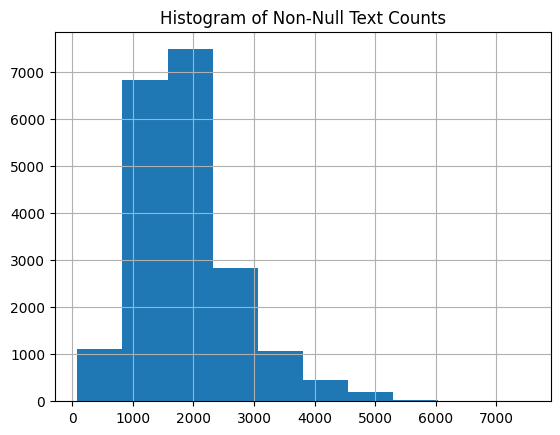

In [19]:
#Plot the histogram for the count of non null values
df_sample['nonNullTextCount'].hist().set_title('Histogram of Non-Null Text Counts')

In [20]:
# Summary statistics
sample_summary = df_sample['nonNullTextCount'].describe()
# Approx 5 chars per word
print(sample_summary.to_string())

count    20000.000000
mean      1875.089050
std        823.902934
min         84.000000
25%       1305.000000
50%       1737.000000
75%       2249.000000
max       7529.000000


####**`Word level Exploration`**

In [21]:
# function to plot the histogram
def plot_histogram(x):
    x.str.split().map(lambda x: len(x)).hist()

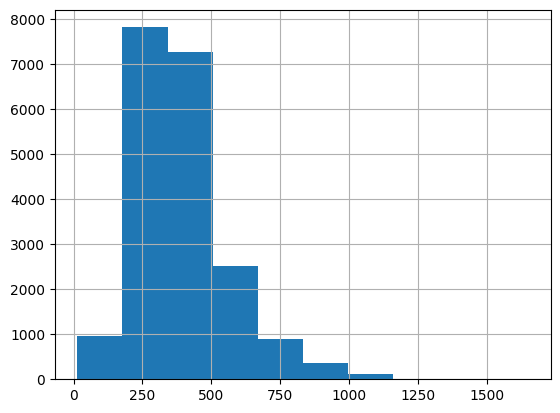

In [22]:
#apply to the sample text column
plot_histogram(df_sample['text'])

####**`Analyzing Label Counts/ Class Distribution`**

In [23]:
labelCount = df['generated'].value_counts()
print("Human written texts: ", labelCount[0])
print("AI generated texts: ", labelCount[1])
print("Total: ", labelCount.sum())

Human written texts:  305797
AI generated texts:  181438
Total:  487235


In [24]:
#import plot
#alternative would be to use seaborn
'''
import seaborn as sns
sns.countplot(x='generated', data=df)
plt.title('Distribution of Generated Labels (0 = Human, 1 = AI)')
plt.show()

'''

"\nimport seaborn as sns\nsns.countplot(x='generated', data=df)\nplt.title('Distribution of Generated Labels (0 = Human, 1 = AI)')\nplt.show()\n\n"

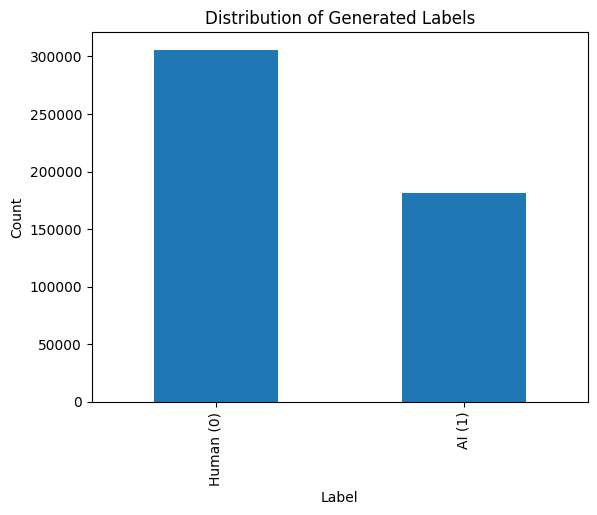

In [25]:
#display a bar plot for the same
df['generated'].value_counts().plot(kind='bar')
plt.xticks([0, 1], ['Human (0)', 'AI (1)'])
plt.title('Distribution of Generated Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [26]:
#Calculate their percentage
human_percentage = (labelCount[0] / labelCount.sum()) * 100
ai_percentage = (labelCount[1] / labelCount.sum()) * 100

print(f"Percentage of Human Written Texts: {human_percentage:.2f}%")
print(f"Percentage of AI Generated Texts: {ai_percentage:.2f}%")

Percentage of Human Written Texts: 62.76%
Percentage of AI Generated Texts: 37.24%


**`Findings and Observations:`**
* `Human-written texts make up 62.76% of the dataset.`
* `AI-generated texts account for 37.24% of the dataset.`
* `There is a moderate class imbalance, with Human (0) samples being more prevalent than AI (1) samples by a ratio of approximately 1.68:1.`
* `Despite the imbalance, the AI class is still significantly represented (over 180K samples), which is sufficient for training robust classification models.`




####**`Analyzing Vocabulary`**

In [27]:
#Additional Imports
import nltk
from nltk.corpus import stopwords
from collections import  Counter

In [28]:
#acquire all stop words in english
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
#Helper function that helps build the corpus
def build_corpus(x):
    corpus=[]
    text = x['text'].str.split()
    text = text.values.tolist()
    corpus = [word for line in text for word in line]
    return corpus

In [30]:
#make a corpus for the sample
corpus=build_corpus(df_sample)

#add words from corpus to the dictionary
from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

<BarContainer object of 10 artists>

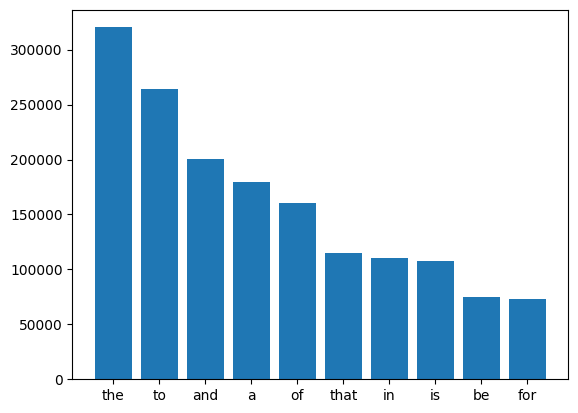

In [31]:
#These are the listed top stop words found in the sample from the text column
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
x,y=zip(*top)
plt.bar(x,y)

<Axes: >

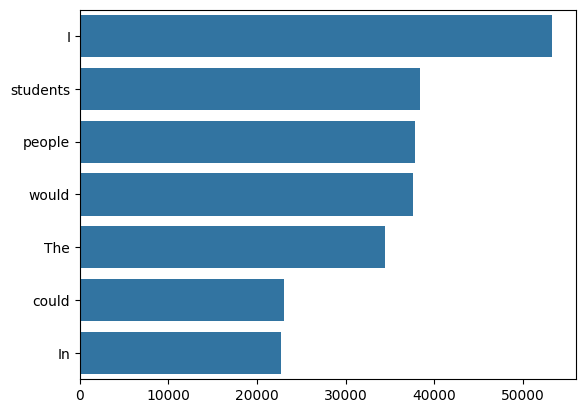

In [32]:

#the following code will analyse the top non stop words used in the sample
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

**`Let us take a look at the vocabulary size for the AI generated text and the Human written repsectively`**

In [33]:
#This part of the code will analyse the vocabulary size for the AI and Human text
# Split dataset
df_human = df_sample[df_sample['generated'] == 0]
df_ai = df_sample[df_sample['generated'] == 1]

# Build corpora
corpusH = build_corpus(df_human)
corpusAI = build_corpus(df_ai)

# Compute vocabulary sizes (excluding stopwords)
vocabH = set([word.lower() for word in corpusH if word.lower() not in stop])
vocabAI = set([word.lower() for word in corpusAI if word.lower() not in stop])

print(f"Human Vocabulary Size: {len(vocabH)}")
print(f"AI Vocabulary Size: {len(vocabAI)}")


Human Vocabulary Size: 76877
AI Vocabulary Size: 51734


In [34]:
#Overlap between human and AI vocabulary
overlap = vocabH & vocabAI
print(f"Shared Vocabulary Size: {len(overlap)}")

Shared Vocabulary Size: 27988


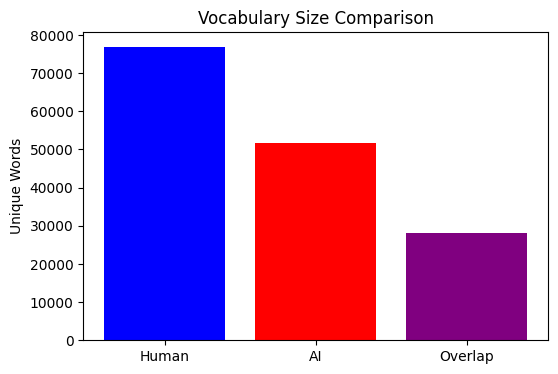

In [35]:
# Plot Vocabulary Size Comparison
plt.figure(figsize=(6,4))
plt.bar(['Human', 'AI', 'Overlap'], [len(vocabH), len(vocabAI), len(overlap)], color=['blue', 'red', 'purple'])
plt.title("Vocabulary Size Comparison")
plt.ylabel("Unique Words")
plt.show()

###**`Basic Processing using NLTK Tokenization on a sample text`**

In [36]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import sent_tokenize
import string
from nltk.tokenize import word_tokenize
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [37]:
#access a sample text; the first entry
sample = df.iat[0,0]
print(sample)

Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.

In like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go. Article, "

In [38]:
#ensuring the type for sample is str
print(type(sample))

<class 'str'>


In [39]:
#see the tokenised sentences
sent_tokens = sent_tokenize(sample)
print(sent_tokens)

['Cars.', 'Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT.', 'Cars have played a major role in our every day lives since then.', 'But now, people are starting to question if limiting car usage would be a good thing.', 'To me, limiting the use of cars might be a good thing to do.', 'In like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes.', 'Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe.', 'Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States.', 'Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where th

In [40]:
#tokenize
word_tokens = word_tokenize(sample)
print(word_tokens)

['Cars', '.', 'Cars', 'have', 'been', 'around', 'since', 'they', 'became', 'famous', 'in', 'the', '1900s', ',', 'when', 'Henry', 'Ford', 'created', 'and', 'built', 'the', 'first', 'ModelT', '.', 'Cars', 'have', 'played', 'a', 'major', 'role', 'in', 'our', 'every', 'day', 'lives', 'since', 'then', '.', 'But', 'now', ',', 'people', 'are', 'starting', 'to', 'question', 'if', 'limiting', 'car', 'usage', 'would', 'be', 'a', 'good', 'thing', '.', 'To', 'me', ',', 'limiting', 'the', 'use', 'of', 'cars', 'might', 'be', 'a', 'good', 'thing', 'to', 'do', '.', 'In', 'like', 'matter', 'of', 'this', ',', 'article', ',', '``', 'In', 'German', 'Suburb', ',', 'Life', 'Goes', 'On', 'Without', 'Cars', ',', "''", 'by', 'Elizabeth', 'Rosenthal', 'states', ',', 'how', 'automobiles', 'are', 'the', 'linchpin', 'of', 'suburbs', ',', 'where', 'middle', 'class', 'families', 'from', 'either', 'Shanghai', 'or', 'Chicago', 'tend', 'to', 'make', 'their', 'homes', '.', 'Experts', 'say', 'how', 'this', 'is', 'a', 'hu

In [41]:
#convert to lower case
tokens = [w.lower() for w in word_tokens]

In [42]:

#remove punctuation and stop words
tokens = [tok for tok in tokens if tok.lower() not in stop and tok not in string.punctuation]
print(tokens)

['cars', 'cars', 'around', 'since', 'became', 'famous', '1900s', 'henry', 'ford', 'created', 'built', 'first', 'modelt', 'cars', 'played', 'major', 'role', 'every', 'day', 'lives', 'since', 'people', 'starting', 'question', 'limiting', 'car', 'usage', 'would', 'good', 'thing', 'limiting', 'use', 'cars', 'might', 'good', 'thing', 'like', 'matter', 'article', '``', 'german', 'suburb', 'life', 'goes', 'without', 'cars', "''", 'elizabeth', 'rosenthal', 'states', 'automobiles', 'linchpin', 'suburbs', 'middle', 'class', 'families', 'either', 'shanghai', 'chicago', 'tend', 'make', 'homes', 'experts', 'say', 'huge', 'impediment', 'current', 'efforts', 'reduce', 'greenhouse', 'gas', 'emissions', 'tailpipe', 'passenger', 'cars', 'responsible', '12', 'percent', 'greenhouse', 'gas', 'emissions', 'europe', '...', '50', 'percent', 'carintensive', 'areas', 'united', 'states', 'cars', 'main', 'reason', 'greenhouse', 'gas', 'emissions', 'lot', 'people', 'driving', 'around', 'time', 'getting', 'need', '

In [43]:
# tokens = [tok.strip('\'\"`“”‘’…—–-()[]{}<>.') for tok in tokens if tok.strip('\'\"`“”‘’…—–-()[]{}<>.')]
#remove other characters which are not necessary
tokens = [tok for tok in tokens if re.fullmatch(r'[A-Za-z]+', tok)]
print(tokens)

['cars', 'cars', 'around', 'since', 'became', 'famous', 'henry', 'ford', 'created', 'built', 'first', 'modelt', 'cars', 'played', 'major', 'role', 'every', 'day', 'lives', 'since', 'people', 'starting', 'question', 'limiting', 'car', 'usage', 'would', 'good', 'thing', 'limiting', 'use', 'cars', 'might', 'good', 'thing', 'like', 'matter', 'article', 'german', 'suburb', 'life', 'goes', 'without', 'cars', 'elizabeth', 'rosenthal', 'states', 'automobiles', 'linchpin', 'suburbs', 'middle', 'class', 'families', 'either', 'shanghai', 'chicago', 'tend', 'make', 'homes', 'experts', 'say', 'huge', 'impediment', 'current', 'efforts', 'reduce', 'greenhouse', 'gas', 'emissions', 'tailpipe', 'passenger', 'cars', 'responsible', 'percent', 'greenhouse', 'gas', 'emissions', 'europe', 'percent', 'carintensive', 'areas', 'united', 'states', 'cars', 'main', 'reason', 'greenhouse', 'gas', 'emissions', 'lot', 'people', 'driving', 'around', 'time', 'getting', 'need', 'go', 'article', 'paris', 'bans', 'drivin

In [44]:
#Apply Porter Stemming to the tokens.
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
#Apply WordNet Lemmatization to the tokens.
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [45]:
#Print the results after each step (tokenization, lowercasing, stopword/punctuation removal, stemming, lemmatization).
print("Sentence Tokenization: ",sent_tokens)
print("Word Tokenization: ",word_tokens)
print("Lower Case Tokens: ",tokens)
print("No stop words/ Original:", tokens)
print("Stemmed:", [stemmer.stem(w) for w in tokens])
print("Lemmatized (noun):", [lemmatizer.lemmatize(w, pos='n') for w in tokens])
print("Lemmatized (verb):", [lemmatizer.lemmatize(w, pos='v') for w in tokens])

Sentence Tokenization:  ['Cars.', 'Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT.', 'Cars have played a major role in our every day lives since then.', 'But now, people are starting to question if limiting car usage would be a good thing.', 'To me, limiting the use of cars might be a good thing to do.', 'In like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes.', 'Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe.', 'Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States.', 'Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all t

In [46]:
#Using spaCy:
#Load a spaCy English model (e.g., en_core_web_sm).
import spacy
nlp = spacy.load("en_core_web_sm")  # load English model
#Process the same sample review using spaCy.
doc = nlp(sample)

In [47]:
#Iterate through the processed Doc object. For each token, print its text, lemma (token.lemma_), POS tag (token.pos_), and whether it's a stopword (token.is_stop).
for token in doc:
    print(token.text, token.pos_, token.lemma_)

Cars NOUN car
. PUNCT .
Cars NOUN car
have AUX have
been AUX be
around ADV around
since SCONJ since
they PRON they
became VERB become
famous ADJ famous
in ADP in
the DET the
1900s NOUN 1900
, PUNCT ,
when SCONJ when
Henry PROPN Henry
Ford PROPN Ford
created VERB create
and CCONJ and
built VERB build
the DET the
first ADJ first
ModelT. ADJ modelt.
Cars NOUN car
have AUX have
played VERB play
a DET a
major ADJ major
role NOUN role
in ADP in
our PRON our
every DET every
day NOUN day
lives VERB live
since SCONJ since
then ADV then
. PUNCT .
But CCONJ but
now ADV now
, PUNCT ,
people NOUN people
are AUX be
starting VERB start
to PART to
question VERB question
if SCONJ if
limiting VERB limit
car NOUN car
usage NOUN usage
would AUX would
be AUX be
a DET a
good ADJ good
thing NOUN thing
. PUNCT .
To ADP to
me PRON I
, PUNCT ,
limiting VERB limit
the DET the
use NOUN use
of ADP of
cars NOUN car
might AUX might
be AUX be
a DET a
good ADJ good
thing NOUN thing
to PART to
do VERB do
. PUNCT .


 S

##**`!!!!!!!Decision making on the tokenization and overall preprocessing process: NLTK vs Spacy!!!!!!!!`**

* Summary: Due to the size of the data set we use spacy for faster approach. Preprocessing using nltk's non optimsed lemmatizer would be unwise, thus spacy would process batches superfast

###**`Preprocessing Pipeline`**

####**`The function`**

In [48]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

####**`Apply on a copy of the original data`**

In [50]:
i=0
def preprocess_text(text, method='lemma'):
  #tokenize into words
  word_tokens = word_tokenize(text)
  #convert to lower case
  tokens = [w.lower() for w in word_tokens]
  #Remove punctuation and stopwords (use NLTK's English stopwords list).
  #remove punctuation and stop words
  stop_words = set(stopwords.words('english'))
  tokens = [tok for tok in tokens if tok.lower() not in stop and tok not in string.punctuation]
  #remove other characters which are not necessary
  tokens = [tok for tok in tokens if re.fullmatch(r'[A-Za-z]+', tok)]
  if method == 'lemma':
    #Apply WordNet Lemmatization to the tokens.
    lemmatizer = WordNetLemmatizer()
    processed= [lemmatizer.lemmatize(w, pos='n') for w in tokens]
  else:
    #Apply Porter Stemming to the tokens.
    stemmer = PorterStemmer()
    processed= [stemmer.stem(w) for w in tokens]
  single_str = ' '.join(processed) #return string joined by spaces
  global i
  i += 1
  print(f"Processing row {i}")
  return single_str

In [51]:
copy_df= df.copy()
copy_df.head()

,text,generated,text_length
0,Cars. Cars have been around since they became ...,0.0,3289
1,Transportation is a large necessity in most co...,0.0,2738
2,"""America's love affair with it's vehicles seem...",0.0,4428
3,How often do you ride in a car? Do you drive a...,0.0,4013
4,Cars are a wonderful thing. They are perhaps o...,0.0,4698


In [52]:
copy_df['processed_lemmatized'] = copy_df['text'].apply(preprocess_text, method="lemma")

Streaming output truncated to the last 5000 lines.
Processing row 482236
Processing row 482237
Processing row 482238
Processing row 482239
Processing row 482240
Processing row 482241
Processing row 482242
Processing row 482243
Processing row 482244
Processing row 482245
Processing row 482246
Processing row 482247
Processing row 482248
Processing row 482249
Processing row 482250
Processing row 482251
Processing row 482252
Processing row 482253
Processing row 482254
Processing row 482255
Processing row 482256
Processing row 482257
Processing row 482258
Processing row 482259
Processing row 482260
Processing row 482261
Processing row 482262
Processing row 482263
Processing row 482264
Processing row 482265
Processing row 482266
Processing row 482267
Processing row 482268
Processing row 482269
Processing row 482270
Processing row 482271
Processing row 482272
Processing row 482273
Processing row 482274
Processing row 482275
Processing row 482276
Processing row 482277
Processing row 482278
Pro

In [53]:
copy_df.head()

,text,generated,text_length,processed_lemmatized
0,Cars. Cars have been around since they became ...,0.0,3289,car car around since became famous henry ford ...
1,Transportation is a large necessity in most co...,0.0,2738,transportation large necessity country worldwi...
2,"""America's love affair with it's vehicles seem...",0.0,4428,america love affair vehicle seems cooling say ...
3,How often do you ride in a car? Do you drive a...,0.0,4013,often ride car drive one motor vehicle work st...
4,Cars are a wonderful thing. They are perhaps o...,0.0,4698,car wonderful thing perhaps one world greatest...


##**`Implementing The Baseline Model`:**

###**`Classic machine learning classifier using scikitlearn`**

In [55]:
from sklearn.model_selection import train_test_split

#Split your data into training and testing sets.
#Use the processed_lemmatized column as your input feature text and the 'label' column as your target
input = copy_df['processed_lemmatized']
target = copy_df['generated']

In [56]:

#Use an 80/20 split (test_size=0.2) and set random_state for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(input, target, test_size=0.2, random_state=42)

In [57]:
print("X_train:\n", X_train)
print("\nX_test:\n", X_test)
print("\ny_train:\n", y_train)
print("\ny_test:\n", y_test)

X_train:
 110501    think facs useful technology could benefit cla...
262291    student create summer project instead teacher ...
159503    average student developed talent playing guita...
193029    holy avocado new computer software come design...
31127     title cowboy rode wave upon time lived cowboy ...
                                ...                        
259178    work together improve people life impact techn...
365838    advantage limiting car usage result healthier ...
131932    good idea student finish high school three yea...
146867    offering distance learning option student atte...
121958    school budget stretched school considering cha...
Name: processed_lemmatized, Length: 389788, dtype: object

X_test:
 419952    real fake feeling imagine able detect exactly ...
478535    seeking multiple opinion help make better choi...
133753    february dear think kid community service inte...
68011     dear believe cell phone need stay home order s...
195939    believe comp

In [58]:
#Initialize a TfidfVectorizer (or CountVectorizer - choose one).
from sklearn.feature_extraction.text import TfidfVectorizer

In [59]:
#Fit the vectorizer on the training data (X_train) only.
tfidf_vec = TfidfVectorizer()
tfidf_matrix = tfidf_vec.fit_transform(X_train)

In [60]:
#Transform both the training data (X_train) and the testing data (X_test) using the fitted vectorizer.
X_train_vec = tfidf_matrix
X_test_vec = tfidf_vec.transform(X_test)

###**`Performance score and analysis`**

In [62]:
#Choose a simple classifier, such as Naive Bayes
from sklearn.naive_bayes import MultinomialNB

In [63]:
#Train the classifier using the vectorized training data and corresponding training labels (y_train).
clf = MultinomialNB()
clf.fit(X_train_vec, y_train)

MultinomialNB()

In [64]:
#Make predictions on the vectorized test data (X_test_vec).
predictions = clf.predict(X_test_vec)
print(predictions)

[0. 0. 0. ... 0. 0. 1.]


In [65]:
#Calculate and print the accuracy of your classifier using sklearn.metrics.accuracy_score.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.95
Precision: 0.97
Recall: 0.89
F1 Score: 0.93
